# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [18]:
%matplotlib inline

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [9]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

In [106]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x,limit=1e3, **kwargs):
    
    condition = np.isfinite(x) & (x < limit)
    sns.distplot(x[condition], **kwargs)

def robust_perc(x, q):
    
    condition = np.isfinite(x)
    return np.percentile(x[condition], q)

### Perform some basic filtering

In [11]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [12]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [13]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


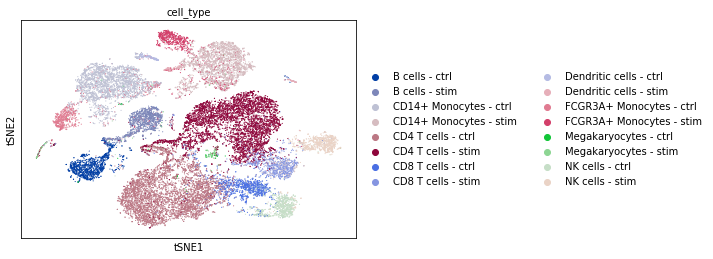

In [19]:
sc.pl.tsne(adata, color='cell_type')

In [20]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [21]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


In [22]:
adata.shape

(24673, 3593)

### Select immune genes using GO annotations

In [23]:
go_annotations = pd.read_csv(data_path + '../../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [24]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [25]:
immune_genes = list(set(adata.var.index) & set(immune_genes))

In [26]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(immune_genes, f)

In [27]:
len(immune_genes)

855

### Pick out TFs to measure DC in

In [28]:
tfs = pd.read_csv('gene_attribute_matrix.txt', sep='\t').columns.tolist()[3:]
tfs_in_highcount = list(set(tfs) & set(adata.var.index))
manual_tfs = """IRF2BP2
STAT4
IRF2
ATF6B
IRF7
STAT6
IRF9
IRF8
AATF
JUNB
ATF5
ATF4""".split()
tfs_to_consider = manual_tfs + tfs_in_highcount

In [29]:
for gene in adata.var.index:
    if ('JUN' in gene or 'ATF' in gene or 'FOS' in gene or 'STAT' in gene or 'IRF' in gene) and (gene not in tfs_in_highcount):
        print(gene)

IRF2BP2
STAT4
IRF2
ATF6B
IRF7
STAT6
IRF9
IRF8
AATF
JUNB
ATF5
ATF4


In [30]:
with open(data_path + 'all_highcount_tfs.pkl', 'wb') as f:
    pkl.dump(tfs_to_consider, f)

In [31]:
len(set(tfs_to_consider))

68

### Read the DC results into long form and heatmaps

In [125]:
tf_batch_nums = np.arange(14)
cts = ['CD4 T cells', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']

In [183]:
heatmaps = {}
ct_dfs = []
for ct in cts:
    heatmaps[ct] = {}
    
    df_list = []
    for tf_batch_num in tf_batch_nums:
        with open(data_path + 'tf_correlations/stim_effect_2d_{}_{}.pkl'.format(ct, tf_batch_num), 'rb') as f:
            dc_dict = pkl.load(f)
            
        first = True
        for attribute, value in dc_dict.items():
            
            if 'gene_idx' in attribute: continue
                        
            # Create the TF x Gene heatmap for each attribute
            attribute_df = pd.DataFrame(
                dc_dict[attribute], 
                index=adata.var.index[dc_dict['gene_idx_1']],
                columns=adata.var.index[dc_dict['gene_idx_2']]).T
            
            # Create attribute heatmaps
            if tf_batch_num == 0:
                heatmaps[ct][attribute] = attribute_df.copy()
            else:
                heatmaps[ct][attribute] = pd.concat([heatmaps[ct][attribute], attribute_df], axis=1)
                
            # Create melted dataframes for easy querying
            attribute_df['gene'] = attribute_df.index
            melted_attribute_df = pd.melt(
                attribute_df, 
                id_vars=['gene'], 
                value_vars=attribute_df.columns[:-1], 
                var_name='tf', value_name=attribute)
            
            # Add columns instead of join for speed
            if first:
                df = melted_attribute_df.copy()
                first=False
            else:
                df[attribute] = melted_attribute_df[attribute]
        
        df_list.append(df)
    ct_df = pd.concat(df_list)
    ct_df['ct'] = ct
    ct_dfs.append(ct_df)
dc_df = pd.concat(ct_dfs)
dc_df['mag_corr_diff'] = dc_df['corr_2'].abs() - dc_df['corr_1'].abs()

        

### Scatter plots

In [101]:
a = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['corr_1']

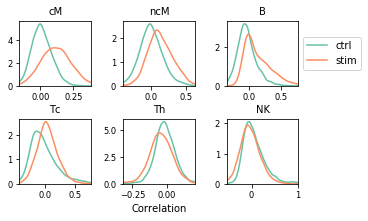

In [171]:
label_mapping = {
    'CD14+ Monocytes':'cM',
    'FCGR3A+ Monocytes':'ncM',
    'B cells':'B',
    'CD8 T cells':'Tc',
    'CD4 T cells':'Th',
    'NK cells':'NK'
}

plt.figure(figsize=(5, 3));
plt.subplots_adjust(hspace=0.5, wspace=0.45)

sns.set_palette('Set2')
tf = 'STAT1'
for ct_idx, ct in enumerate(['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'B cells', 'CD8 T cells', 'CD4 T cells', 'NK cells']):


        plt.subplot(2, 3, ct_idx+1)

        corr_1 = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['corr_1']
        corr_2 = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['corr_2']
        corr_diff = dc_df.query('tf == "{}" & ct == "{}"'.format(tf, ct))['dcorr_diff']

        robust_hist(corr_1, hist=False, label='ctrl' if ct == 'B cells' else None)
        robust_hist(corr_2, hist=False, label='stim' if ct == 'B cells' else None)
        #robust_hist(corr_diff, hist=False)

        perc_lim = 1
        x_min = min(robust_perc(corr_1, perc_lim), robust_perc(corr_2, perc_lim))
        x_max = max(robust_perc(corr_1, 100-perc_lim), robust_perc(corr_2, 100-perc_lim))

        plt.xlim(x_min, x_max)
        #plt.legend()
        #plt.title(ct)

        plt.title(label_mapping[ct])

        plt.xlabel('')

        if ct == 'B cells':
            plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


#     if ct == 'NK cells':
#         plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
        if ct == 'CD4 T cells':
            plt.xlabel('Correlation')

### Selection process for TFs

In [173]:
ct = 'CD14+ Monocytes'

In [193]:
stim_corr_mat = heatmaps[ct]['corr_2']#.drop('gene', axis=1)
stim_corr_mat['gene'] = stim_corr_mat.index
stim_corr_mat['stim'] = 1

ctrl_corr_mat = heatmaps[ct]['corr_1']#.drop('gene', axis=1)
ctrl_corr_mat['stim'] = 0
ctrl_corr_mat['gene'] = ctrl_corr_mat.index

corr_mat = pd.concat([stim_corr_mat, ctrl_corr_mat], ignore_index=True).dropna()
X = corr_mat.iloc[:, :-2]
y = corr_mat['stim']

In [195]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', C=0.2).fit(X, y)

In [188]:
data.sort_values('gene').head(10)

,AATF,ATF1,ATF3,ATF4,ATF5,ATF6B,BACH1,BATF,BCLAF1,BDP1,...,STAT2,STAT3,STAT4,STAT6,TAF7,THAP1,YY1,ZNF274,gene,stim
1806,0.084972,-0.024851,0.049405,-0.146324,0.204109,-0.019175,0.159552,-0.010766,-0.188532,0.081844,...,0.163807,-0.024398,-0.057640,-0.026658,0.018325,-0.011023,-0.043791,-0.030513,AAED1,1
5399,-0.054926,-0.345343,0.017276,-0.190065,-0.020550,-0.402859,0.022816,-0.245030,0.052382,0.097331,...,0.451424,0.066817,-0.046032,-0.152507,0.080009,-0.255177,-0.048664,-0.026947,AAED1,0
614,0.217243,0.546282,-0.165936,0.294013,-0.144253,0.045602,0.079830,0.019098,0.653739,-0.184924,...,0.018731,0.457491,-0.088556,-0.211559,0.445529,0.279270,-0.171686,-0.102073,AAMP,1
4207,0.028846,-0.094589,-0.105223,-0.067701,-0.114978,-0.024766,-0.313856,-0.149660,0.374651,-0.226678,...,-0.098664,-0.106222,0.129751,0.009584,-0.174538,0.207766,-0.134744,0.068620,AAMP,0
5787,-0.299072,0.425415,0.247394,0.086785,0.423457,0.070932,-0.039832,-0.347669,0.044229,1.013074,...,-0.166826,0.411779,-0.167486,-0.011859,0.124118,0.288786,0.037049,-0.111066,AASDHPPT,0
2194,0.318020,0.385502,0.126867,-0.368108,0.422855,-0.059725,-0.010737,-0.160495,0.352861,0.039676,...,0.028593,-0.200563,0.323947,0.492422,0.257450,-0.141103,-0.188809,0.122343,AASDHPPT,1
6541,NaN,0.372662,-0.099936,-0.161141,-0.030577,0.127937,-0.138948,-0.226379,-0.070972,-0.314385,...,-0.174915,0.130670,-0.127905,0.521206,-0.146663,-0.058549,-0.118588,-0.107280,AATF,0
2948,NaN,0.512096,-0.130542,0.124122,-0.248992,0.508233,-0.317429,0.295354,0.999735,0.063544,...,-0.302936,0.191224,0.054852,-0.378414,0.348701,0.246020,-0.056639,0.384898,AATF,1
4556,0.227595,-0.074072,0.081326,-0.014172,0.005801,-0.224863,-0.101927,0.121488,0.139052,0.601418,...,-0.125239,0.023243,0.238791,0.278023,0.219423,0.043479,0.021576,-0.016478,ABCE1,0
963,0.581441,-0.237021,0.192806,0.412308,0.066593,-0.216368,0.728262,-0.102683,1.412022,-0.175401,...,0.060105,-0.030954,0.965535,-0.220684,0.190261,0.341248,0.001869,-0.167728,ABCE1,1


In [176]:
stim_corr_mat.head(5)

index,IRF2BP2,STAT4,IRF2,ATF6B,IRF7,STAT6,IRF9,IRF8,AATF,JUNB,...,ETS1,CHD2,CBX3,RAD21,IRF3,ATF3,KDM5A,CHD1,ZNF274,NELFE
index,,,,,,,,,,,,,,,,,,,,,
NOC2L,0.163432,0.064478,0.151068,0.021704,0.242815,0.006393,0.107206,0.488093,-0.093180,0.154814,...,-0.056214,0.224622,0.090147,0.130915,-0.012141,-0.104906,-0.014956,0.277038,0.026021,0.114149
HES4,-0.038057,0.030955,0.067991,-0.041326,0.144987,0.096760,0.089318,-0.029559,0.038036,-0.049211,...,-0.122775,0.020530,-0.025554,-0.053051,-0.121676,0.025936,-0.022946,-0.053320,0.072508,0.026915
ISG15,-0.207828,0.089221,0.093661,-0.074812,0.061945,0.111046,0.057533,-0.151371,-0.001819,-0.118653,...,-0.105133,-0.092888,-0.066061,-0.051249,-0.225310,0.098591,-0.075891,-0.194997,0.042179,-0.090333
TNFRSF18,0.108000,0.164596,-0.046350,0.157287,0.068016,-0.001131,-0.032358,-0.008671,-0.092083,0.110317,...,-0.029534,-0.105154,0.068575,-0.005862,-0.057563,0.029754,-0.011239,-0.113028,0.150065,-0.032775
SDF4,0.086174,0.026847,-0.151927,0.171414,0.048540,0.278469,0.057191,-0.017402,-0.173267,0.030554,...,-0.080476,-0.030849,0.015002,0.276795,0.119596,-0.010602,0.141833,0.058804,-0.031048,0.017942


In [172]:
dc_df.head(5)

,gene,tf,dcov_diff,dcov_pval,dcov_fdr,cov_1,cov_2,dcorr_diff,dcorr_pval,dcorr_fdr,corr_1,corr_2,ct,mag_corr_diff
0,NOC2L,IRF2BP2,-0.044617,0.679932,0.941004,-0.071679,-0.116296,-0.072188,0.322768,0.863883,-0.034130,-0.106317,CD4 T cells,0.072188
1,HES4,IRF2BP2,0.220984,0.009999,0.277133,-0.020896,0.200089,0.151993,0.015198,0.472681,-0.016307,0.135686,CD4 T cells,0.119378
2,ISG15,IRF2BP2,0.790717,0.697130,0.946440,0.185119,0.975836,0.013419,0.850515,0.985376,0.007829,0.021248,CD4 T cells,0.013419
3,TNFRSF18,IRF2BP2,0.130111,0.115588,0.664906,-0.092297,0.037815,0.066964,0.189581,0.807402,-0.039141,0.027823,CD4 T cells,-0.011318
4,SDF4,IRF2BP2,0.006812,0.896310,0.985492,-0.008629,-0.001817,0.001124,0.967503,0.998151,-0.003012,-0.001887,CD4 T cells,-0.001124


### Some general trends

In [40]:
dc_df_sig = dc_df.query('dcorr_fdr < 0.1')

In [90]:
immune_genes[:5]

['DDT', 'CMTM3', 'CAPZA1', 'GAPDH', 'CD3D']

In [ ]:
dc_df_sig.sort_values('')

In [96]:
dc_df.query('gene in @immune_genes')

,gene,tf,dcov_diff,dcov_pval,dcov_fdr,cov_1,cov_2,dcorr_diff,dcorr_pval,dcorr_fdr,corr_1,corr_2,ct,mag_corr_diff
2,ISG15,IRF2BP2,0.790717,0.697130,0.946440,0.185119,0.975836,0.013419,0.850515,0.985376,0.007829,0.021248,CD4 T cells,0.013419
3,TNFRSF18,IRF2BP2,0.130111,0.115588,0.664906,-0.092297,0.037815,0.066964,0.189581,0.807402,-0.039141,0.027823,CD4 T cells,-0.011318
16,TNFRSF14,IRF2BP2,-0.042290,0.616738,0.926045,-0.093118,-0.135408,-0.052056,0.506949,0.926829,-0.067877,-0.119933,CD4 T cells,0.052056
21,VAMP3,IRF2BP2,0.024391,0.407759,0.862586,-0.074320,-0.049929,0.020304,0.655334,0.955785,-0.090280,-0.069976,CD4 T cells,-0.020304
22,PARK7,IRF2BP2,-0.609254,0.150385,0.703180,0.462868,-0.146387,-0.119308,0.143186,0.771612,0.064722,-0.054587,CD4 T cells,-0.010135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17954,MX1,JUND,2.408471,0.547945,0.938483,-0.767984,1.640488,0.145943,0.285371,0.879328,-0.103151,0.042792,FCGR3A+ Monocytes,-0.060359
17956,PDXK,JUND,-0.411817,0.606339,0.952910,0.532389,0.120572,-0.150095,0.509349,0.937297,0.182896,0.032801,FCGR3A+ Monocytes,-0.150095
17957,CSTB,JUND,-1.077742,0.748725,0.971682,-2.476601,-3.554342,0.013157,0.941906,0.995458,-0.108758,-0.095601,FCGR3A+ Monocytes,-0.013157
17959,PFKL,JUND,0.010074,0.932307,0.993229,0.051261,0.061335,0.004513,0.900110,0.990779,0.022408,0.026921,FCGR3A+ Monocytes,0.004513


### Make some heatmaps

In [59]:
a = dc_df_sig.query('tf == "FOS"')

(-0.5, 1)

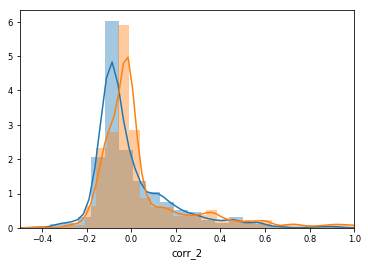

In [63]:
sns.distplot(a['corr_1'], label='control')
sns.distplot(a['corr_2'], label='stim')
plt.xlim(-0.5, 1)

In [60]:
a.head(5)

,gene,tf,dcov_diff,dcov_pval,dcov_fdr,cov_1,cov_2,dcorr_diff,dcorr_pval,dcorr_fdr,corr_1,corr_2,ct,mag_corr_diff
14393,VAMP3,FOS,0.192604,0.001000,0.138140,-0.051819,0.140786,0.109798,4.144104e-19,3.718297e-15,-0.036296,0.073501,CD4 T cells,0.037205
14400,FBXO6,FOS,-0.174001,0.000001,0.000755,0.035232,-0.138770,-0.088805,5.524238e-05,1.208932e-02,0.029544,-0.059261,CD4 T cells,0.029718
14491,YBX1,FOS,-3.479217,0.000144,0.028687,2.466854,-1.012363,-0.189511,2.402049e-06,7.982365e-04,0.128162,-0.061349,CD4 T cells,-0.066813
14495,ELOVL1,FOS,-0.157473,0.007799,0.330363,0.115709,-0.041764,-0.057825,1.520581e-10,2.480620e-07,0.027443,-0.030382,CD4 T cells,0.002939
14546,LMO4,FOS,-0.438110,0.001000,0.138140,0.388076,-0.050034,-0.138260,1.768400e-05,4.599121e-03,0.108360,-0.029900,CD4 T cells,-0.078460


In [57]:
for ct in cts:
    print(ct, '-----------')
    print(dc_df_sig.query('ct == "{}" & mag_corr_diff < 0 & mag_corr_diff > -0.9'.format(ct)).sort_values('mag_corr_diff').head(200).tf.value_counts().head(10))

CD4 T cells -----------
BACH1    33
ATF5     17
ATF4     13
FOS      11
BDP1     10
STAT2    9 
AATF     8 
CREB1    7 
PML      5 
MBD4     5 
Name: tf, dtype: int64
CD8 T cells -----------
SPI1       51
ATF5       15
STAT6      12
STAT2      9 
IRF2BP2    7 
E2F4       6 
STAT3      6 
FOS        6 
STAT4      6 
ATF6B      5 
Name: tf, dtype: int64
B cells -----------
CEBPD      33
ATF5       17
ATF4       15
BHLHE40    12
H2AFZ      11
MYC        11
ATF1       8 
GATA3      8 
RELA       8 
FOS        6 
Name: tf, dtype: int64
CD14+ Monocytes -----------
STAT4      31
GATA3      27
CEBPB      25
IRF7       17
HSF1       14
MYC        13
BATF       7 
BDP1       7 
ATF6B      5 
BHLHE40    5 
Name: tf, dtype: int64
NK cells -----------
HSF1       23
IRF9       17
STAT6      15
SMARCC1    9 
SMC3       8 
BACH1      8 
RELA       8 
BHLHE40    7 
STAT1      7 
THAP1      7 
Name: tf, dtype: int64
FCGR3A+ Monocytes -----------
RELA       70
CEBPZ      25
BATF       13
IRF2BP2    8 
GA

In [54]:
dc_df_sig.query('ct == "CD4 T cells" & mag_corr_diff < 0 & mag_corr_diff > -0.9').sort_values('mag_corr_diff').head(200).tf.value_counts().head(10)

BACH1    33
ATF5     17
ATF4     13
FOS      11
BDP1     10
STAT2    9 
AATF     8 
CREB1    7 
PML      5 
MBD4     5 
Name: tf, dtype: int64

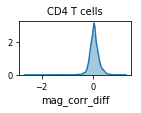

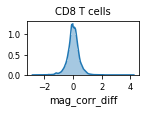

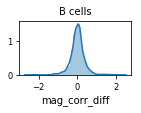

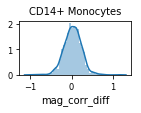

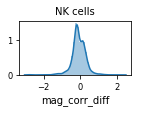

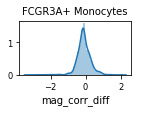

In [46]:
for ct in cts:
    
    plt.figure(figsize=(2, 1))
    robust_hist(dc_df_sig.query('ct == "{}"'.format(ct))['mag_corr_diff'])
    plt.title(ct)


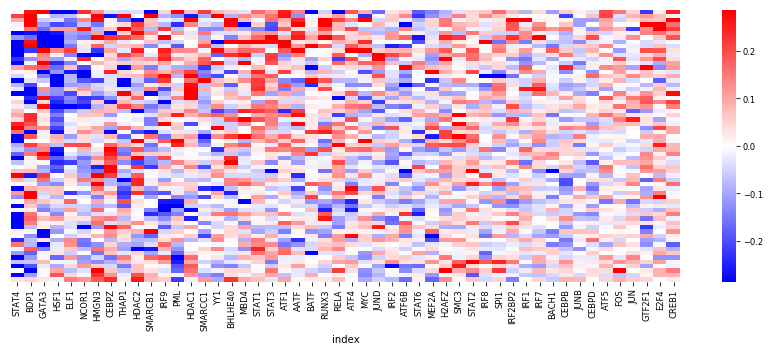

In [38]:
ct = 'CD14+ Monocytes'

# Find DC genes for this ct
genes = dc_df_sig.query('ct == "CD14+ Monocytes" & dcorr_diff < -0.5')['gene'].drop_duplicates().tolist()

# Get the sig heatmap
hm = heatmaps[ct]['corr_2'].loc[genes, :].drop('gene', axis=1).abs() - heatmaps[ct]['corr_1'].loc[genes, :].drop('gene', axis=1).abs()
hm[~np.isfinite(hm)] = 0

perc = np.percentile(np.abs(hm.values).ravel(), 95)
hm[hm < -perc] = -perc
hm[hm > perc] = perc

order_gene = hm.index[sns.clustermap(hm, cmap='RdBu', center=0).dendrogram_row.reordered_ind]; plt.close()
order_tf = hm.columns[sns.clustermap(hm, cmap='RdBu', center=0).dendrogram_col.reordered_ind]; plt.close()


# show heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(hm.loc[order_gene, order_tf], cmap='bwr', center=0, xticklabels=1)
plt.gca().get_yaxis().set_visible(False)

In [119]:
hm = heatmaps[ct]['corr_1'].loc[genes, :]

In [117]:
genes

,gene,tf,dcov_diff,dcov_pval,dcov_fdr,cov_1,cov_2,dcorr_diff,dcorr_pval,dcorr_fdr,corr_1,corr_2,ct
305,RCSD1,IRF2BP2,0.135832,3.599640e-02,0.326183,-0.079239,0.056593,0.266451,9.999000e-04,0.086313,-0.192895,0.073556,CD14+ Monocytes
317,CACYBP,IRF2BP2,1.933454,3.199680e-03,0.083164,-0.421418,1.512036,0.325856,1.399860e-03,0.098182,-0.045879,0.279977,CD14+ Monocytes
380,TSNAX,IRF2BP2,-0.235421,1.499850e-02,0.206892,0.176585,-0.058836,-0.269657,9.999000e-04,0.086313,0.157224,-0.112433,CD14+ Monocytes
871,MRFAP1L1,IRF2BP2,0.311289,1.999800e-03,0.061186,-0.206365,0.104924,0.511831,9.999000e-04,0.086313,-0.210619,0.301212,CD14+ Monocytes
967,PLRG1,IRF2BP2,-0.332016,3.799620e-02,0.335833,0.176520,-0.155496,-0.423440,2.387762e-04,0.029772,0.107394,-0.316046,CD14+ Monocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14772,RSAD2,JUND,-15.886819,1.359884e-03,0.197964,0.549211,-15.337608,-0.309524,1.740605e-05,0.004465,0.104212,-0.205312,CD14+ Monocytes
15862,MKRN1,JUND,1.239063,4.213588e-05,0.022932,-0.833978,0.405084,0.568936,6.553125e-06,0.002092,-0.378008,0.190928,CD14+ Monocytes
16024,CCDC25,JUND,0.305080,5.169045e-07,0.000619,-0.187457,0.117623,0.644450,7.012073e-05,0.015594,-0.366458,0.277992,CD14+ Monocytes
16594,ETS1,JUND,-0.244567,1.399860e-03,0.197964,0.213639,-0.030928,-0.458176,6.270814e-08,0.000161,0.323901,-0.134275,CD14+ Monocytes


In [114]:
heatmaps[ct]['corr_1']

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [62]:
long_df = pd.melt(df, id_vars=['gene'], value_vars=df.columns[:-1], var_name='tf', value_name='dcorr_diff')

In [63]:
df.head(5)

index,IRF2BP2,STAT4,IRF2,ATF6B,IRF7,gene
index,,,,,,
NOC2L,-0.072188,0.049347,-0.023656,-0.156435,-0.071723,NOC2L
HES4,0.151993,0.042800,0.025193,0.177007,0.165992,HES4
ISG15,0.013419,0.047270,-0.129700,-0.017586,0.315396,ISG15
TNFRSF18,0.066964,-0.038506,-0.093558,-0.040862,-0.034298,TNFRSF18
SDF4,0.001124,0.138142,0.040192,0.063334,0.097016,SDF4


In [69]:
long_df[(dc_dict['dcorr_diff'].ravel() != long_df['dcorr_diff'])]

,gene,tf,dcorr_diff
253,RPS27,IRF2BP2,NaN
383,IRF2BP2,IRF2BP2,NaN
2786,IL27,IRF2BP2,NaN
3445,FPR3,IRF2BP2,NaN
3846,RPS27,STAT4,NaN
4181,STAT4,STAT4,NaN
6379,IL27,STAT4,NaN
7038,FPR3,STAT4,NaN
7439,RPS27,IRF2,NaN
8161,IRF2,IRF2,NaN


In [64]:
long_df.head(5)

,gene,tf,dcorr_diff
0,NOC2L,IRF2BP2,-0.072188
1,HES4,IRF2BP2,0.151993
2,ISG15,IRF2BP2,0.013419
3,TNFRSF18,IRF2BP2,0.066964
4,SDF4,IRF2BP2,0.001124


### Magnitude of correlation and covariance between STAT1 and downstream genes increases upon IFN-B stimulation

In [24]:
cts = ['CD4 T cells', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']
tfs = ['JUN',
    'ATF3',
    'STAT1',
    'STAT4',
    'FOXP1',
    'ATF6B',
    'ATF1',
    'STAT2',
    'STAT6',
    'FOS',
    'BATF',
    'AATF',
    'STAT3',
    'JUNB',
    'JUND',
    'ATF5',
    'ATF4']

In [123]:
ct = 'CD14+ Monocytes'
# ct = 'FCGR3A+ Monocytes'
# ct = 'CD4 T cells'
# ct = 'CD8 T cells'

tf = 'JUN'
tf = 'ATF4'
tf = 'STAT6'
with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
    stim_2d_dict = pkl.load(f)

In [124]:
stim_heatmap = stim_2d_dict['corr_2']
stim_heatmap[~np.isfinite(stim_heatmap)] = 0
stim_heatmap = pd.DataFrame(stim_heatmap.T, columns=tfs, index=immune_genes)

In [125]:
ctrl_heatmap = stim_2d_dict['corr_1']
ctrl_heatmap[~np.isfinite(ctrl_heatmap)] = 0
ctrl_heatmap = pd.DataFrame(ctrl_heatmap.T, columns=tfs, index=immune_genes)

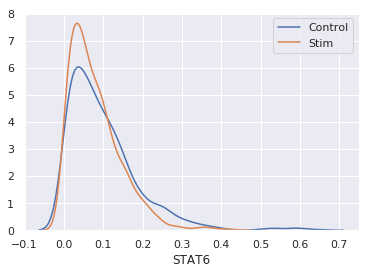

In [127]:
sns.distplot(ctrl_heatmap[tf].abs(), hist=False, label='Control')
sns.distplot(stim_heatmap[tf].abs(), hist=False, label='Stim')
plt.legend(['Control', 'Stim'])
#plt.xlim(-0.3, 0.6)
#sns.distplot(stim_heatmap['STAT1'] - ctrl_heatmap['STAT1'], hist=False)

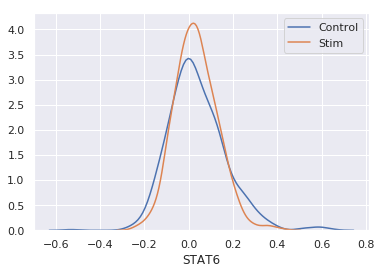

In [126]:
sns.distplot(ctrl_heatmap[tf], hist=False, label='Control')
sns.distplot(stim_heatmap[tf], hist=False, label='Stim')
plt.legend(['Control', 'Stim'])
#plt.xlim(-0.3, 0.6)
#sns.distplot(stim_heatmap['STAT1'] - ctrl_heatmap['STAT1'], hist=False)

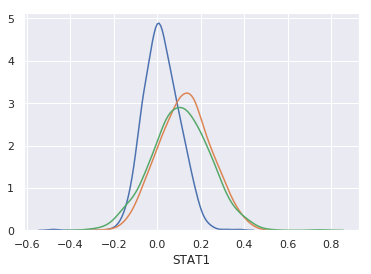

In [96]:
ct = 'CD4 T cells'
ct = 'CD14+ Monocytes'
# ct = 'CD8 T cells'
# ct = 'B cells'
with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
    stim_2d_dict = pkl.load(f)
    
stim_heatmap = stim_2d_dict['corr_2']
#stim_heatmap[~np.isfinite(stim_heatmap)] = 0
stim_heatmap = pd.DataFrame(stim_heatmap.T, columns=tfs, index=immune_genes)

ctrl_heatmap = stim_2d_dict['corr_1']
#ctrl_heatmap[~np.isfinite(ctrl_heatmap)] = 0
ctrl_heatmap = pd.DataFrame(ctrl_heatmap.T, columns=tfs, index=immune_genes)

sns.distplot(ctrl_heatmap['STAT1'], hist=False)
sns.distplot(stim_heatmap['STAT1'], hist=False)
sns.distplot(stim_heatmap['STAT1'] - ctrl_heatmap['STAT1'], hist=False)

In [42]:
diff = stim_heatmap['STAT1'] - ctrl_heatmap['STAT1']

In [45]:
stim_heatmap['STAT1'] - ctrl_heatmap['STAT1']

In [46]:
mag_diff.mean()

0.040228126711188805

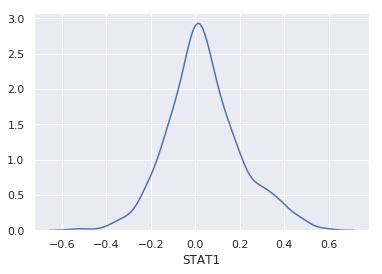

In [44]:
sns.distplot(stim_heatmap['STAT1'].abs() - ctrl_heatmap['STAT1'].abs(), hist=False)

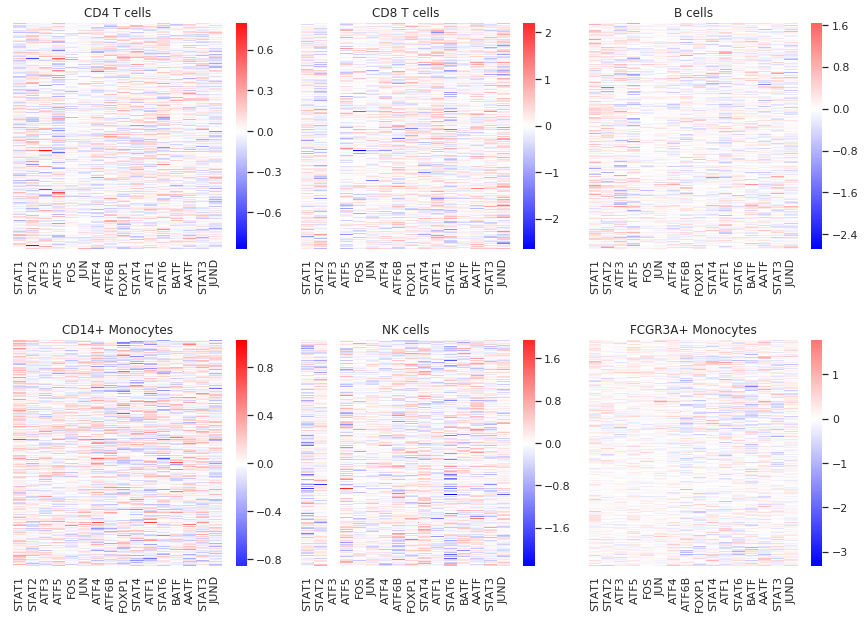

In [118]:
sns.set(font_scale=1)
plt.figure(figsize=(15, 10));
plt.subplots_adjust(hspace=0.4, wspace=0.1)
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)

    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)

    heatmap = stim_2d_dict['corr_2'] - stim_2d_dict['corr_1'] 
    heatmap[~np.isfinite(heatmap)] = 0
    heatmap = pd.DataFrame(heatmap.T, columns=tfs, index=immune_genes)#[['STAT1', 'FOS']]
    
    order = heatmap.index[sns.clustermap(heatmap, cmap='RdBu', center=0).dendrogram_row.reordered_ind]; plt.close()

    sns.heatmap(
        heatmap.loc[
            order_switch+order_nonswitch, 
            ['STAT1', 'STAT2', 'ATF3','ATF5','FOS', 'JUN','ATF4', 'ATF6B', 'FOXP1', 'STAT4', 'ATF1', 'STAT6', 'BATF', 'AATF', 'STAT3', 'JUND']
        ], 
        cmap='bwr', center=0, xticklabels=1)

    plt.gca().get_yaxis().set_visible(False)
    plt.title(ct)
sns.set()


0.12136397328108345
0.32587312729949913
0.2752840783297309
0.16297521466771098
0.29396079321377583
0.2834340451224543


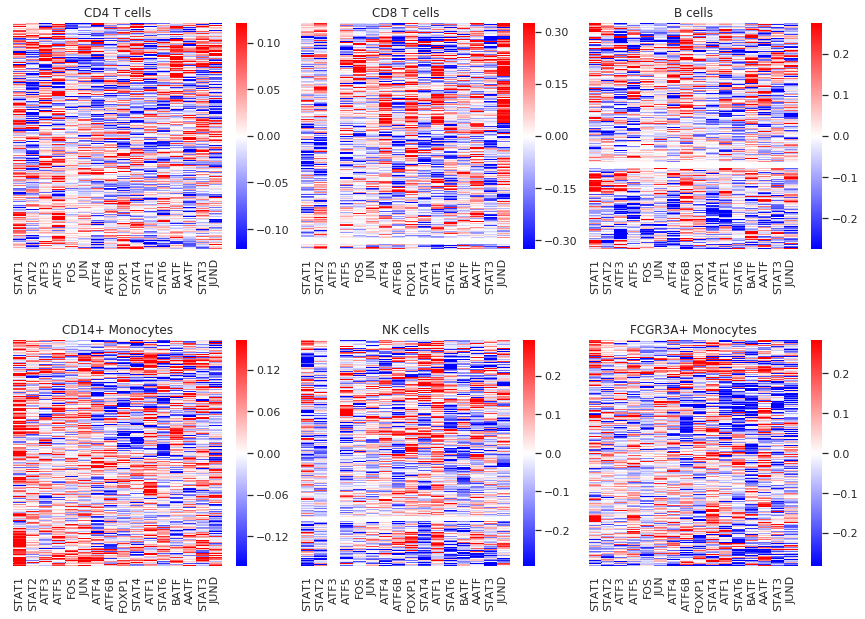

In [25]:
switch_genes_dict = {}
sns.set(font_scale=1)
plt.figure(figsize=(15, 10));
plt.subplots_adjust(hspace=0.4, wspace=0.1)
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)

    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)

    heatmap = np.abs(stim_2d_dict['corr_2']) - np.abs(stim_2d_dict['corr_1'])
    heatmap[~np.isfinite(heatmap)] = 0

    perc = np.percentile(np.abs(heatmap).ravel(), 90)
    print(perc)
    heatmap[heatmap < -perc] = -perc
    heatmap[heatmap > perc] = perc
    heatmap = pd.DataFrame(heatmap.T, columns=tfs, index=immune_genes)#[['STAT1', 'FOS']]

    
    switch_genes = heatmap.query('STAT1 > 0 & STAT2 > 0 & FOS < 0 & JUN < 0').index.tolist()
    switch_genes_dict[ct] = switch_genes.copy()
    order_nonswitch = sns.clustermap(heatmap.loc[~heatmap.index.isin(switch_genes),:], cmap='RdBu', center=0).dendrogram_row.reordered_ind; plt.close()
    order_nonswitch = heatmap.loc[~heatmap.index.isin(switch_genes), heatmap.columns != 'JUNB'].index[order_nonswitch].tolist()

    order_switch = sns.clustermap(heatmap.loc[heatmap.index.isin(switch_genes), :], cmap='RdBu', center=0).dendrogram_row.reordered_ind; plt.close()
    order_switch = heatmap.loc[heatmap.index.isin(switch_genes), heatmap.columns != 'JUNB'].index[order_switch].tolist()

    sns.heatmap(
        heatmap.loc[
            order_switch+order_nonswitch, 
            ['STAT1', 'STAT2', 'ATF3','ATF5','FOS', 'JUN','ATF4', 'ATF6B', 'FOXP1', 'STAT4', 'ATF1', 'STAT6', 'BATF', 'AATF', 'STAT3', 'JUND']
        ], 
        cmap='bwr', center=0, xticklabels=1)

    plt.gca().get_yaxis().set_visible(False)
    plt.title(ct)
sns.set()


### Scatter plot form

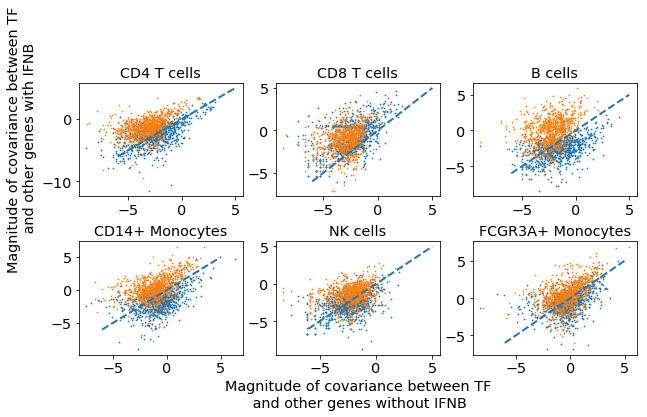

In [127]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
            
    plt.scatter(
        np.log(np.abs(stim_2d_dict['cov_1'][9, :])),
        np.log(np.abs(stim_2d_dict['cov_2'][9, :])),
        s=0.5
    )

    plt.scatter(
        np.log(np.abs(stim_2d_dict['cov_1'][2, :])),
        np.log(np.abs(stim_2d_dict['cov_2'][2, :])),
        s=0.5
    )
    
    plt.plot([-6, 5], [-6, 5], '--', lw=2)
    
    
    plt.title(ct)

    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF\n and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between TF\n and other genes with IFNB')

In [156]:
for ct in cts:
    print('\'' + ct + '\':')

'CD4 T cells':
'CD8 T cells':
'B cells':
'CD14+ Monocytes':
'NK cells':
'FCGR3A+ Monocytes':


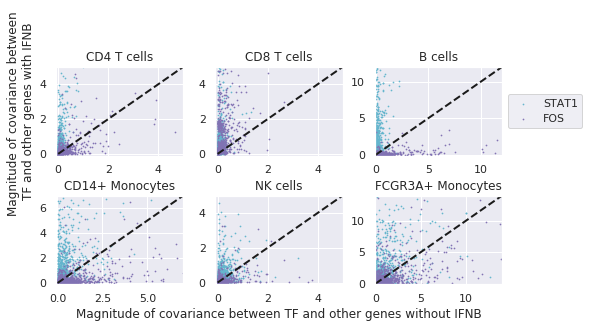

In [24]:
plt.figure(figsize=(8, 4));
plt.subplots_adjust(hspace=0.45, wspace=0.25)

max_vals = {
    'CD4 T cells':5,
    'CD8 T cells':5,
    'B cells':12,
    'CD14+ Monocytes':7,
    'NK cells':5,
    'FCGR3A+ Monocytes':14,
}

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
        
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][2, :]),
        np.abs(stim_2d_dict['cov_2'][2, :]),
        s=0.5,
        label='STAT1',
        color='c'
    )
    
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][9, :]),
        np.abs(stim_2d_dict['cov_2'][9, :]),
        s=0.5,
        label='FOS',
        color='m'
    )


    plt.plot([0, max_vals[ct]], [0, max_vals[ct]], '--', lw=2, c='k')
    plt.ylim(-.1, max_vals[ct])
    plt.xlim(-.1, max_vals[ct])
    
    
    plt.title(ct)
    
    if ct == 'B cells':
        plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between \nTF and other genes with IFNB')

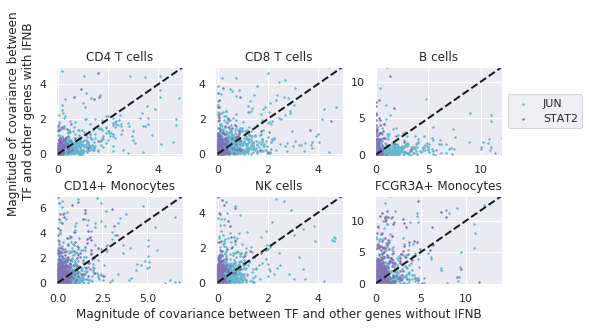

In [26]:
plt.figure(figsize=(8, 4));
plt.subplots_adjust(hspace=0.45, wspace=0.25)

max_vals = {
    'CD4 T cells':5,
    'CD8 T cells':5,
    'B cells':12,
    'CD14+ Monocytes':7,
    'NK cells':5,
    'FCGR3A+ Monocytes':14,
}

for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
        stim_2d_dict = pkl.load(f)
        
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][0, :]),
        np.abs(stim_2d_dict['cov_2'][0, :]),
        s=2,
        label='JUN',
        color='c'
    )
    
    plt.scatter(
        np.abs(stim_2d_dict['cov_1'][7, :]),
        np.abs(stim_2d_dict['cov_2'][7, :]),
        s=2,
        label='STAT2',
        color='m'
    )


    plt.plot([0, max_vals[ct]], [0, max_vals[ct]], '--', lw=2, c='k')
    plt.ylim(-.1, max_vals[ct])
    plt.xlim(-.1, max_vals[ct])
    
    
    plt.title(ct)
    
    if ct == 'B cells':
        plt.legend(bbox_to_anchor=(1,0.5),loc='center left')


    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between TF and other genes without IFNB')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Magnitude of covariance between \nTF and other genes with IFNB')

### Network drawing

In [24]:
ct = 'CD14+ Monocytes'
with open(data_path + 'stim_effect_2d_ap1_stat_{}.pkl'.format(ct), 'rb') as f:
    stim_2d_dict = pkl.load(f)

In [25]:
tf_gene_idxs = stim_2d_dict['gene_idx_1']

In [28]:
import networkx as nx
tfs_considered = ['STAT1', 'STAT2','FOS', 'JUN',]
genes_considered = switch_genes_dict[ct]#[:15]

In [29]:
len(genes_considered)

193

In [30]:
# Create the control graph
ctrl_df = pd.DataFrame(np.abs(stim_2d_dict['cov_1']).T, columns=tfs, index=immune_genes)
ctrl_G = nx.Graph()
ctrl_G.add_nodes_from(tfs_considered + genes_considered)
for tf in tfs_considered:
    for gene in genes_considered:
        ctrl_G.add_edge(tf, gene, weight=ctrl_df.loc[gene, tf])

# Create the stim graph
stim_df = pd.DataFrame(np.abs(stim_2d_dict['cov_2']).T, columns=tfs, index=immune_genes)
stim_G = nx.Graph()
stim_G.add_nodes_from(tfs_considered + genes_considered)
for tf in tfs_considered:
    for gene in genes_considered:
        stim_G.add_edge(tf, gene, weight=stim_df.loc[gene, tf])

In [48]:
# Generate the positions
pos = {}
for tf_idx, tf in enumerate(tfs_considered):
    pos[tf] = np.array([np.random.uniform(-7, -5), np.random.uniform(-6, 6)]) if tf_idx < len(tfs_considered)/2 else np.array([np.random.uniform(5, 7), np.random.uniform(-6, 6)])
for gene in genes_considered:
    if gene in tfs_considered:
        continue
    pos[gene] = np.array([np.random.uniform(-2, 2), np.random.uniform(-10, 10)])

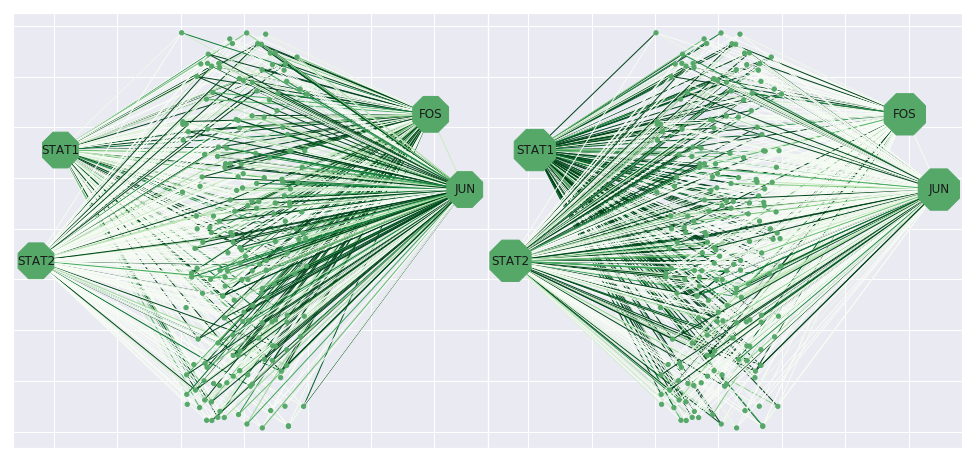

In [49]:
plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0)

edge_colors = np.array([ctrl_G[u][v]['weight'] for u,v in ctrl_G.edges])
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    with_labels=True, 
    width=1, 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=[1500 for i in range(len(tfs_considered))] + [20 for i in range(len(genes_considered))],
    edge_vmin=0.3, 
    edge_vmax=1,
    node_color='g',
    node_shape='8',
    labels={tf:tf for tf in tfs_considered})

plt.subplot(1, 2, 2)
edge_colors = np.array([stim_G[u][v]['weight'] for u,v in stim_G.edges])
nx.draw_networkx(
    stim_G, 
    pos=pos, 
    with_labels=True, 
    width=1, 
    edge_cmap=mpl.cm.Greens, 
    edge_color=edge_colors, 
    node_size=[2000 for i in range(len(tfs_considered))] + [20 for i in range(len(genes_considered))],
    edge_vmin=0.3, 
    edge_vmax=1,
    node_shape='8',
    node_color='g',
    labels={tf:tf for tf in tfs_considered})
#plt.title('IFNB Stimluation')

### Check 1D Hypothesis tests of the TFs

In [20]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_1d_dict = pkl.load(f)

In [30]:
ct = 'CD14+ Monocytes'

In [31]:

list(zip(
    tfs,
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr'][tf_gene_idxs],
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff'][tf_gene_idxs],
))

[('JUN', 0.5986283747826544, -0.19030852778382057),
 ('ATF3', 0.6319349018990368, -0.2959004839166216),
 ('STAT1', 0.12954838779105596, -0.6201531885767011),
 ('STAT4', 0.982612418341671, -0.0008278366735992027),
 ('FOXP1', 0.9957395490722011, 0.023240353370100664),
 ('ATF6B', 0.7039342753747619, 0.3741452847156555),
 ('ATF1', 0.703412311398482, -0.23873828772843636),
 ('STAT2', 0.17261273222121118, -1.5032448384964125),
 ('STAT6', 0.43451690982836505, 0.5205212516790636),
 ('FOS', 0.11462055049275315, -0.6892570852905682),
 ('BATF', 0.8403839373539934, 0.5757373873554044),
 ('AATF', 0.9668329607373896, -0.03200797422934443),
 ('STAT3', 0.6538877375618506, -0.3151068448403085),
 ('JUNB', 0.7990490362827087, 0.07684280103591856),
 ('JUND', 0.3127015311805658, 0.5627964791710258),
 ('ATF5', 0.28676822481880004, -0.3955897268957598),
 ('ATF4', 0.7729121556753094, 0.2098264308075889)]

In [27]:
list(zip(
    tfs,
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr'][tf_gene_idxs],
    stim_1d_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff'][tf_gene_idxs],
))

[('JUN', 6.677715329630336e-07, -0.5536635518074036),
 ('ATF3', 6.302143467215288e-07, 1.5637065172195435),
 ('STAT1', 2.500292611231652e-07, 1.284623622894287),
 ('STAT4', 0.14514009869628935, 0.44343042373657227),
 ('FOXP1', 0.029117397419744385, 0.27544865012168884),
 ('ATF6B', 7.100859126918669e-07, -0.8456469774246216),
 ('ATF1', 7.284302149193766e-05, -0.5637848973274231),
 ('STAT2', 1.8558750691942757e-06, 1.8341100215911865),
 ('STAT6', 0.010801867840740541, 0.3104115128517151),
 ('FOS', 3.076833910293327e-07, -1.5557018518447876),
 ('BATF', 0.0025466909386204564, -0.9345657825469971),
 ('AATF', 9.004703177834318e-07, -0.6128941178321838),
 ('STAT3', 1.2002745736930059e-06, 0.5044786930084229),
 ('JUNB', 1.4630051394421615e-07, -0.19006896018981934),
 ('JUND', 8.991446534258821e-05, -0.36658212542533875),
 ('ATF5', 5.618758955074735e-08, 1.1979399919509888),
 ('ATF4', 3.3435965194647085e-07, -0.4739071726799011)]

### Covariance distribution shifts

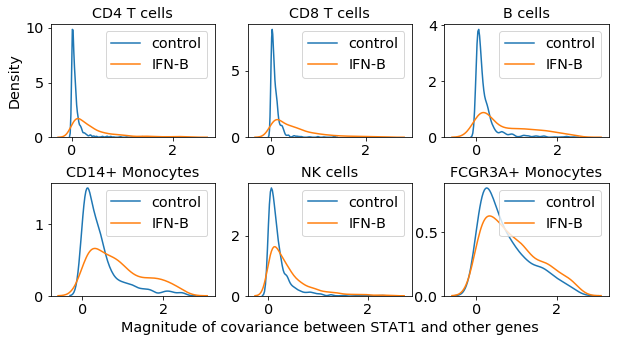

In [383]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 0 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

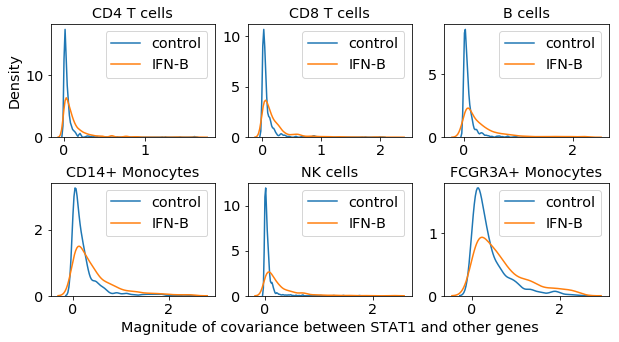

In [679]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 1 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

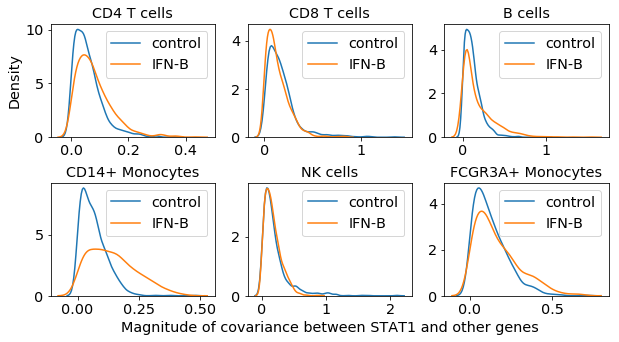

In [384]:
plt.figure(figsize=(10, 5));
plt.subplots_adjust(hspace=0.4)
gene_idx = 0 # referring to STAT1
for ct_idx, ct in enumerate(cts):
    plt.subplot(2, 3, ct_idx+1)
    
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_idx, :]), limit=2.5, hist=False, label='control')
    robust_hist(np.abs(stim_2d_dict[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_idx, :]), limit=2.5, hist=False, label='IFN-B')
    plt.title(ct);
    
    if ct == 'NK cells':
        plt.xlabel('Magnitude of covariance between STAT1 and other genes')
    
    if ct == 'CD4 T cells':
        plt.ylabel('Density')

### Get a list of TFs

In [719]:
len("""JUN
ATF3
IRF2BP2
STAT1
STAT4
IRF2
IRF1
ATF6B
IRF7
ATF1
STAT2
STAT6
IRF9
FOS
BATF
IRF8
AATF
STAT3
JUNB
JUND
IRF3
ATF5
ATF4""".split())

23

In [178]:
tfs_in_highcount = list(set(tfs) & set(adata.var.index))

In [179]:
with open(data_path + 'tfs.pkl', 'wb') as f:
    pkl.dump(tfs_in_highcount, f)

In [195]:
import random
random.shuffle(tfs_in_highcount)

In [198]:
tfs_in_highcount[:30]

['RAD21',
 'CEBPB',
 'STAT1',
 'SMARCB1',
 'CEBPZ',
 'H2AFZ',
 'IRF1',
 'BDP1',
 'FOS',
 'YY1',
 'MEF2A',
 'IRF3',
 'HMGN3',
 'BHLHE40',
 'GATA3',
 'SMARCC1',
 'ATF1',
 'BATF',
 'MAX',
 'SMC3',
 'HDAC2',
 'NELFE',
 'ETS1',
 'IKZF1',
 'CBX3',
 'HSF1',
 'BCLAF1',
 'SPI1',
 'REST',
 'BACH1']

In [180]:
len(tfs_in_highcount)

56

In [45]:
with open(data_path + 'stim_effect_2d_highcount_tfs.pkl', 'rb') as f:
    temp = pkl.load(f)

In [56]:
temp[('CD14+ Monocytes - ctrl','CD14+ Monocytes - stim')]['gene_idx_1']

array([3263])

(array([  1.,   2.,   4.,   3.,  46.,  31.,   7., 135., 242., 384.]),
 array([6.99730736e-04, 1.00579763e-01, 2.00459795e-01, 3.00339827e-01,
        4.00219858e-01, 5.00099890e-01, 5.99979922e-01, 6.99859954e-01,
        7.99739986e-01, 8.99620018e-01, 9.99500050e-01]),
 <a list of 10 Patch objects>)

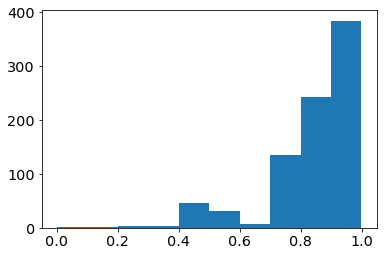

In [54]:
plt.hist(temp[('CD14+ Monocytes - ctrl','CD14+ Monocytes - stim')]['dcov_fdr'].ravel())

In [44]:
for tf in tfs_in_highcount:
    if 'STAT' in tf:
        print(tf)

STAT3
STAT2
STAT1


### Differential correlation/covariance for STAT proteins

In [495]:
with open(data_path + 'stim_effect_2d_ifn_pathway.pkl', 'rb') as f:
    stim_2d_ifn_pathway = pkl.load(f)


In [512]:
def reindex(gene):
    return np.where(stim_2d_dict[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['gene_idx_2'] == adata.var.index.tolist().index(gene))[0][0]

def build_dc_df(ct, tf_idx, result_dict):
    
    df = pd.DataFrame()
    df['gene_idx'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']
    df['gene'] = adata.var.index[result_dict[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']]
    
    df['cov_1'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][tf_idx, :]
    df['cov_2'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][tf_idx, :]
    
    df['cov_1'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_1'][tf_idx, :]
    df['cov_2'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['cov_2'][tf_idx, :]
    
    df['corr_fdrs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcorr_fdr'][tf_idx, :]
    df['corr_diffs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcorr_diff'][tf_idx, :]
    df['cov_fdrs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcov_fdr'][tf_idx, :]
    df['cov_diffs'] = result_dict[(ct + ' - ctrl', ct + ' - stim')]['dcov_diff'][tf_idx, :]
    
    
    return df